In [1]:
# CELL - 1:

import os
import random
import shutil

# Set the path to the CASIA-thousand dataset
dataset_dir = "/kaggle/input/casia-iris/CASIA-Iris-Thousand"

# Set the desired split ratios (e.g., 60% for training, 20% for validation, 20% for testing)
train_split_ratio = 0.6
val_split_ratio = 0.2  # 20% for validation
# The rest will be for testing

# Set the output directories for training, validation, and testing sets
output_train_dir = "/kaggle/working/training-set"
output_val_dir = "/kaggle/working/validation-set"
output_test_dir = "/kaggle/working/testing-set"

# Create the output directories if they don't exist
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_val_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

# Get the list of directories in the dataset directory
directories = [dir for dir in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, dir))]

# Shuffle the directories randomly
random.shuffle(directories)

# Determine the split indices based on the split ratios
train_split_index = int(len(directories) * train_split_ratio)
val_split_index = int(len(directories) * (train_split_ratio + val_split_ratio))

# Split the dataset into training, validation, and testing sets
train_dirs = directories[:train_split_index]
val_dirs = directories[train_split_index:val_split_index]
test_dirs = directories[val_split_index:]

# Function to copy image files from source to destination directory
def copy_images(source_dir, destination_dir):
    image_files = [file for file in os.listdir(source_dir) if file.endswith(".jpg")]
    for file in image_files:
        src_path = os.path.join(source_dir, file)
        dst_path = os.path.join(destination_dir, file)
        shutil.copy(src_path, dst_path)

# Move the training set files to the output training directory
for directory in train_dirs:
    l_dir = os.path.join(dataset_dir, directory, "L")
    r_dir = os.path.join(dataset_dir, directory, "R")
    copy_images(l_dir, output_train_dir)
    copy_images(r_dir, output_train_dir)

# Move the validation set files to the output validation directory
for directory in val_dirs:
    l_dir = os.path.join(dataset_dir, directory, "L")
    r_dir = os.path.join(dataset_dir, directory, "R")
    copy_images(l_dir, output_val_dir)
    copy_images(r_dir, output_val_dir)

# Move the testing set files to the output testing directory
for directory in test_dirs:
    l_dir = os.path.join(dataset_dir, directory, "L")
    r_dir = os.path.join(dataset_dir, directory, "R")
    copy_images(l_dir, output_test_dir)
    copy_images(r_dir, output_test_dir)

print("Dataset split into training, validation, and testing sets successfully.")


Dataset split into training, validation, and testing sets successfully.


In [2]:
import os
import cv2
import numpy as np

# Set the path to the preprocessed training, validation, and testing directories
preprocessed_train_dir = "/kaggle/working/preprocessed-training-set"
preprocessed_val_dir = "/kaggle/working/preprocessed-validation-set"
preprocessed_test_dir = "/kaggle/working/preprocessed-testing-set"

# Create the preprocessed data directories if they don't exist
os.makedirs(preprocessed_train_dir, exist_ok=True)
os.makedirs(preprocessed_val_dir, exist_ok=True)
os.makedirs(preprocessed_test_dir, exist_ok=True)

# Function to perform circular Hough Transform for segmentation
def circular_hough_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=120, param1=80, param2=30, minRadius=40, maxRadius=140)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        (x, y, r) = circles[0]
        iris_region = image[y - r:y + r, x - r:x + r]
        if iris_region.shape[0] > 0 and iris_region.shape[1] > 0:
            return iris_region
    return image

# Preprocessing steps
def preprocess_image(image):
    if image is None:  # Check for None before further processing
        return None
    segmented_image = circular_hough_transform(image)
    preprocessed_image = cv2.resize(segmented_image, (224, 224))
    preprocessed_image = preprocessed_image / 255.0  # Normalize pixel values between 0 and 1
    return preprocessed_image

# Paths to your original train, validation, and test datasets
output_train_dir = "/kaggle/working/training-set"
output_val_dir = "/kaggle/working/validation-set"
output_test_dir = "/kaggle/working/testing-set"

# Initialize counters for failed images
failed_to_load = 0
failed_to_preprocess = 0

# Preprocess the datasets
def preprocess_dataset(input_dir, output_dir):
    global failed_to_load
    global failed_to_preprocess
    for filename in os.listdir(input_dir):
        image_path = os.path.join(input_dir, filename)
        preprocessed_image_path = os.path.join(output_dir, filename)
        
        image = cv2.imread(image_path)
        if image is None:
            failed_to_load += 1
            continue
        preprocessed_image = preprocess_image(image)
        if preprocessed_image is None:
            failed_to_preprocess += 1
            continue
        cv2.imwrite(preprocessed_image_path, (preprocessed_image * 255).astype(np.uint8))

preprocess_dataset(output_train_dir, preprocessed_train_dir)
preprocess_dataset(output_val_dir, preprocessed_val_dir)
preprocess_dataset(output_test_dir, preprocessed_test_dir)

print(f"Data preprocessing completed with {failed_to_load} images failing to load and {failed_to_preprocess} images failing to preprocess.")


Data preprocessing completed with 0 images failing to load and 0 images failing to preprocess.


In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16

# Set the path to the preprocessed training and testing directories
preprocessed_train_dir = "/kaggle/working/preprocessed-training-set"
preprocessed_test_dir = "/kaggle/working/preprocessed-testing-set"
preprocessed_val_dir = "/kaggle/working/preprocessed-validation-set"

# Create the preprocessed data directories if they don't exist
os.makedirs(preprocessed_train_dir, exist_ok=True)
os.makedirs(preprocessed_test_dir, exist_ok=True)
os.makedirs(preprocessed_val_dir, exist_ok=True)

# Load the pre-trained model
vgg16_weights_path = "/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
pretrained_model = VGG16(weights=vgg16_weights_path, include_top=False, pooling='avg')

# Preprocessing steps
def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224))
    preprocessed_image = resized_image / 255.0
    return preprocessed_image

def extract_features(images):
    preprocessed_images = [preprocess_image(image) for image in images]
    preprocessed_images = np.array(preprocessed_images)

    features = pretrained_model.predict(preprocessed_images)
    features = features.reshape(features.shape[0], -1)

    return features

# Batch processing for feature extraction
def process_images(images_dir, preprocessed_dir, batch_size=32):
    image_files = os.listdir(images_dir)
    num_batches = len(image_files) // batch_size

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size

        batch_images = []
        for filename in image_files[start_idx:end_idx]:
            image_path = os.path.join(images_dir, filename)
            image = cv2.imread(image_path)
            batch_images.append(image)

        features = extract_features(batch_images)

        for idx, filename in enumerate(image_files[start_idx:end_idx]):
            features_path = os.path.splitext(filename)[0] + ".npy"
            features_path = os.path.join(preprocessed_dir, features_path)
            np.save(features_path, features[idx])

    remaining_images = len(image_files) % batch_size
    if remaining_images > 0:
        start_idx = num_batches * batch_size
        end_idx = len(image_files)

        batch_images = []
        for filename in image_files[start_idx:end_idx]:
            image_path = os.path.join(images_dir, filename)
            image = cv2.imread(image_path)
            batch_images.append(image)

        features = extract_features(batch_images)

        for idx, filename in enumerate(image_files[start_idx:end_idx]):
            features_path = os.path.splitext(filename)[0] + ".npy"
            features_path = os.path.join(preprocessed_dir, features_path)
            np.save(features_path, features[idx])

# Preprocess the training set
process_images("/kaggle/working/training-set", preprocessed_train_dir)

# Preprocess the testing set
process_images("/kaggle/working/testing-set", preprocessed_test_dir)

# Preprocess the validation set
process_images("/kaggle/working/validation-set", preprocessed_val_dir)

print("Feature extraction completed successfully.")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

1/1 [==============================] - 0s 28ms/step
Feature extraction completed successfully.


In [4]:
import os
import numpy as np
import cv2

def load_preprocessed_features(features_dir):
    feature_files = os.listdir(features_dir)
    features = []
    images = []

    for file in feature_files:
        file_path = os.path.join(features_dir, file)
        
        if file.endswith('.jpg.npy'):  # Handle pickled numpy arrays
            feature = np.load(file_path, allow_pickle=True)
            features.append(feature)
        elif file.endswith('.jpg'):  # Handle regular image files
            # Access the file or perform any necessary operations
            #print("Accessing file:", file_path)
            image = cv2.imread(file_path)  # Load the image
            images.append(image)
        elif file.endswith('.npy'):  # Handle preprocessed numpy arrays
            feature = np.load(file_path)
            features.append(feature)

    features = np.array(features)
    return features, images

train_features, train_images = load_preprocessed_features(preprocessed_train_dir)
test_features, test_images = load_preprocessed_features(preprocessed_test_dir)
validation_features, validation_images = load_preprocessed_features(preprocessed_val_dir)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

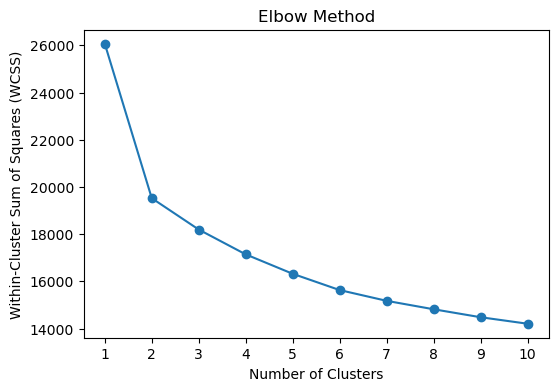

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform clustering using different numbers of clusters
wcss = []  # Within-cluster sum of squares
max_clusters = 10  # Maximum number of clusters to try

for num_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(train_features)
    wcss.append(kmeans.inertia_)  # Append the WCSS value to the list

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.xticks(range(1, max_clusters + 1))
plt.show()

In [6]:
from sklearn.cluster import KMeans

# Perform clustering using KMeans
num_clusters = 2  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(train_features)

# Get cluster labels for training and testing features
train_cluster_labels = kmeans.predict(train_features)
test_cluster_labels = kmeans.predict(test_features)
validation_cluster_labels = kmeans.predict(validation_features)

# Print the cluster labels for training and testing features
#print("Cluster labels for training features:", train_cluster_labels)
#print("Cluster labels for testing features:", test_cluster_labels)
print("Clustering compleated")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering compleated


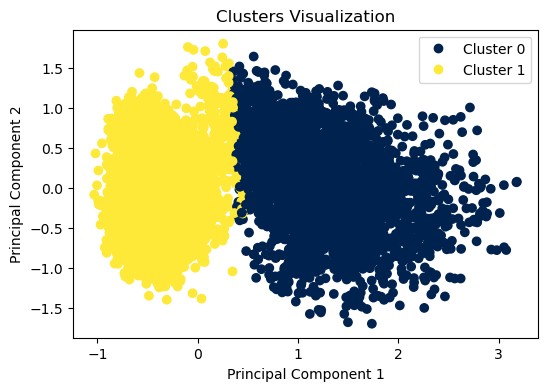

In [7]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reduced_train_features = pca.fit_transform(train_features)

plt.figure(figsize=(6, 4))
scatter = plt.scatter(reduced_train_features[:, 0], reduced_train_features[:, 1], c=train_cluster_labels, cmap='cividis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualization')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

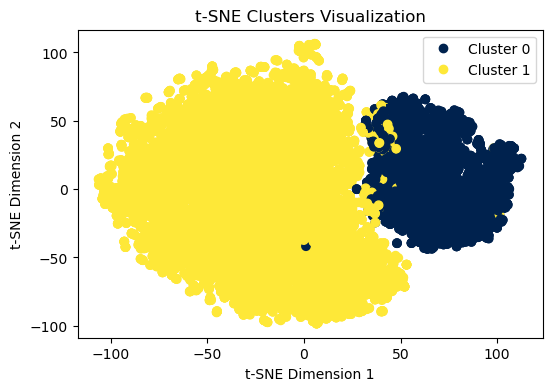

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_train_features_tsne = tsne.fit_transform(train_features)

plt.figure(figsize=(6, 4))
scatter = plt.scatter(reduced_train_features_tsne[:, 0], reduced_train_features_tsne[:, 1], c=train_cluster_labels, cmap='cividis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Clusters Visualization')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

In [9]:
from tensorflow.keras.utils import to_categorical

train_cluster_labels_encoded = to_categorical(train_cluster_labels, num_clusters)
test_cluster_labels_encoded = to_categorical(test_cluster_labels, num_clusters)
validation_cluster_labels_encoded = to_categorical(validation_cluster_labels, num_clusters)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout


model = Sequential()
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_clusters, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
history = model.fit(train_features, train_cluster_labels_encoded, epochs=20, batch_size=64, validation_data=(validation_features, validation_cluster_labels_encoded))


Epoch 1/20
188/188 [==============================] - 3s 5ms/step - loss: 0.2171 - accuracy: 0.9146 - val_loss: 0.0323 - val_accuracy: 0.9918
Epoch 2/20
188/188 [==============================] - 1s 4ms/step - loss: 0.0340 - accuracy: 0.9897 - val_loss: 0.0182 - val_accuracy: 0.9937
Epoch 3/20
188/188 [==============================] - 1s 4ms/step - loss: 0.0219 - accuracy: 0.9926 - val_loss: 0.0157 - val_accuracy: 0.9950
Epoch 4/20
188/188 [==============================] - 1s 4ms/step - loss: 0.0182 - accuracy: 0.9933 - val_loss: 0.0198 - val_accuracy: 0.9915
Epoch 5/20
188/188 [==============================] - 1s 4ms/step - loss: 0.0157 - accuracy: 0.9938 - val_loss: 0.0125 - val_accuracy: 0.9958
Epoch 6/20
188/188 [==============================] - 1s 4ms/step - loss: 0.0145 - accuracy: 0.9944 - val_loss: 0.0115 - val_accuracy: 0.9960
Epoch 7/20
188/188 [==============================] - 1s 4ms/step - loss: 0.0126 - accuracy: 0.9952 - val_loss: 0.0113 - val_accuracy: 0.9960
Epoch 

In [11]:
# Evaluate the model on the testing set
_, accuracy = model.evaluate(test_features, test_cluster_labels_encoded)
print("Accuracy:", accuracy)

125/125 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 0.9967
Accuracy: 0.996749997138977


/tmp/ipykernel_23/2974111154.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


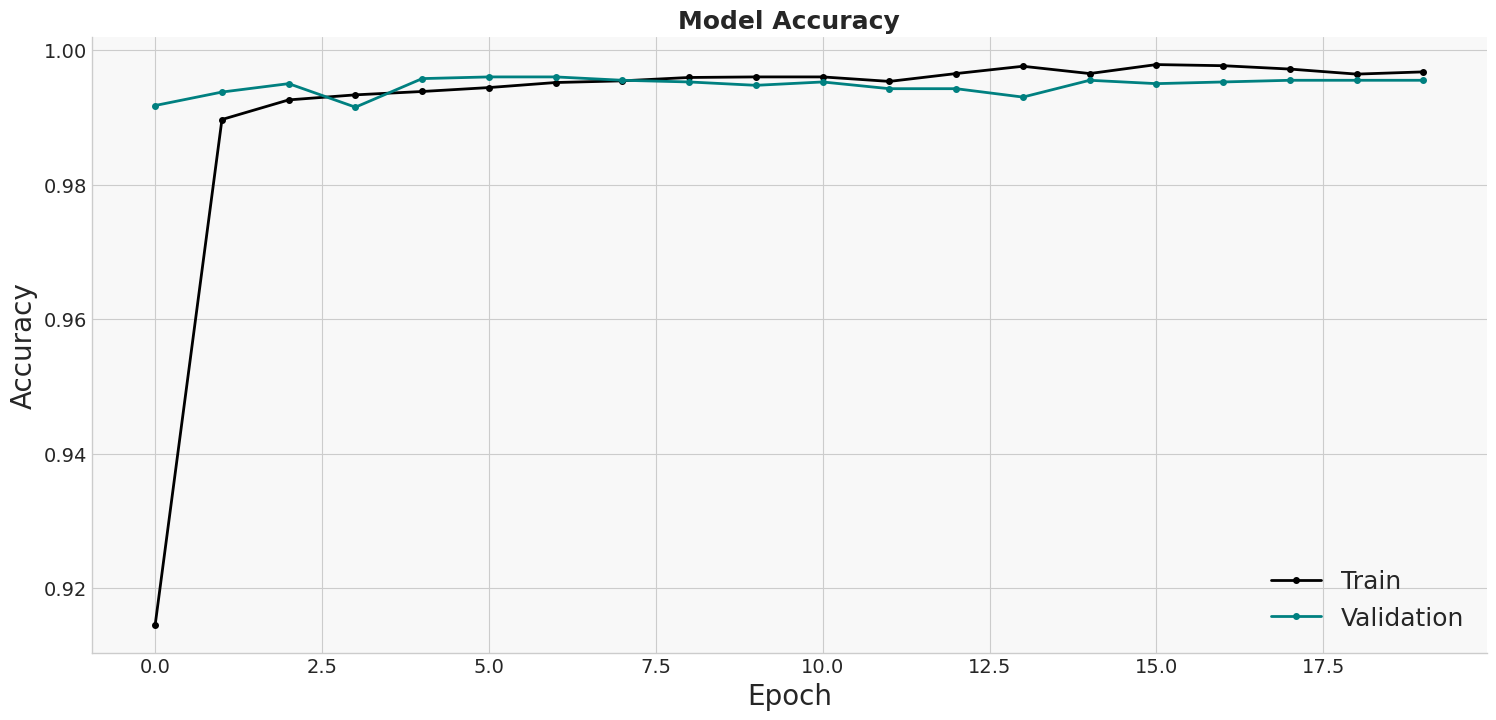

In [12]:
import matplotlib.pyplot as plt

# Set the style and color palette
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000', '#008080'])

# Increase line width and add markers
plt.plot(history.history['accuracy'], linewidth=2, marker='o', markersize=4, label='Train')
plt.plot(history.history['val_accuracy'], linewidth=2, marker='o', markersize=4, label='Validation')

# Customize fonts and adjust figure size
plt.title('Model Accuracy', fontsize=18, fontweight='bold')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gcf().set_size_inches(18, 8)

# Set plot background color
ax = plt.gca()
ax.set_facecolor('#F8F8F8')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()



/tmp/ipykernel_23/3621753908.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


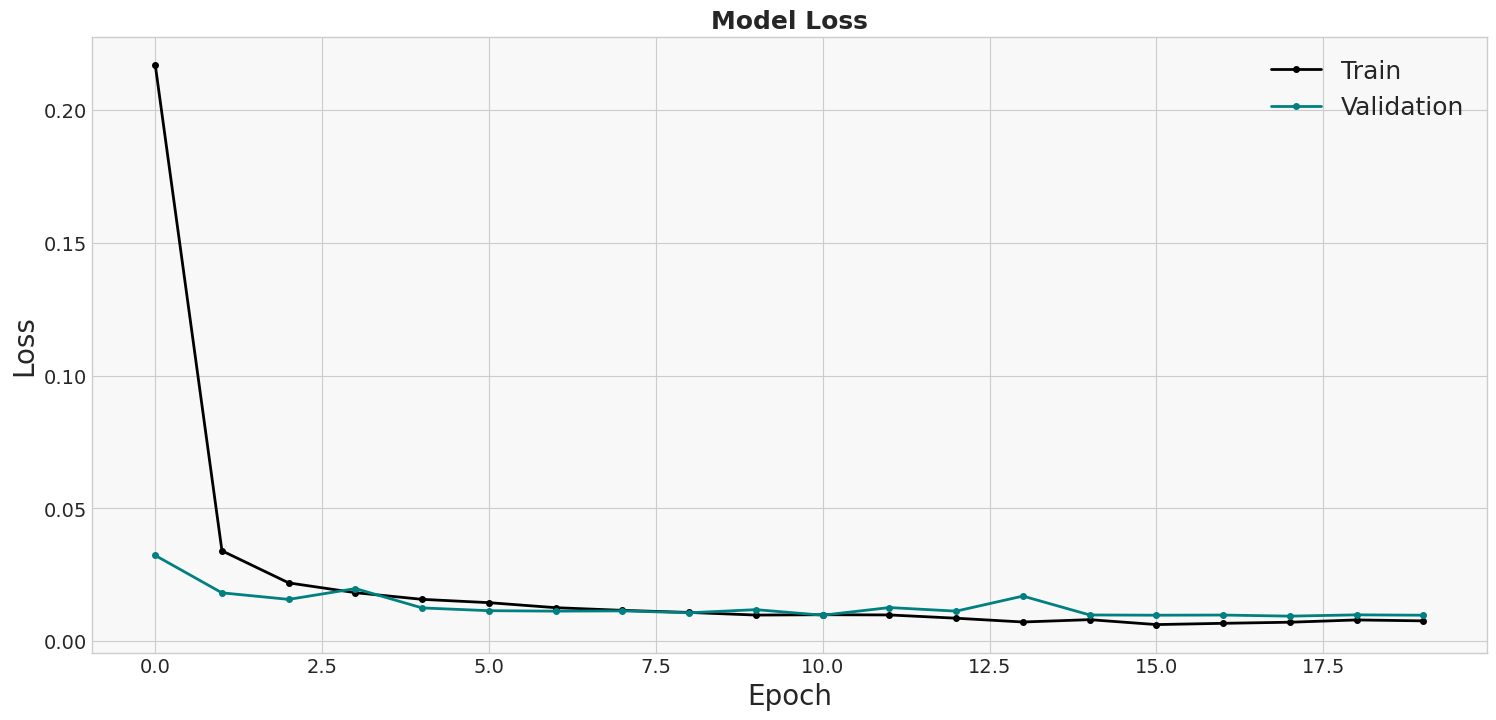

In [13]:
import matplotlib.pyplot as plt

# Set the style and color palette
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000', '#008080'])

# Increase line width and add markers
plt.plot(history.history['loss'], linewidth=2, marker='o', markersize=4, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, marker='o', markersize=4, label='Validation')

# Customize fonts and adjust figure size
plt.title('Model Loss', fontsize=18, fontweight='bold')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gcf().set_size_inches(18, 8)

# Set plot background color
ax = plt.gca()
ax.set_facecolor('#F8F8F8')

# Remove top and right spines
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Show the plot
plt.show()


1/1 [==============================] - 0s 60ms/step


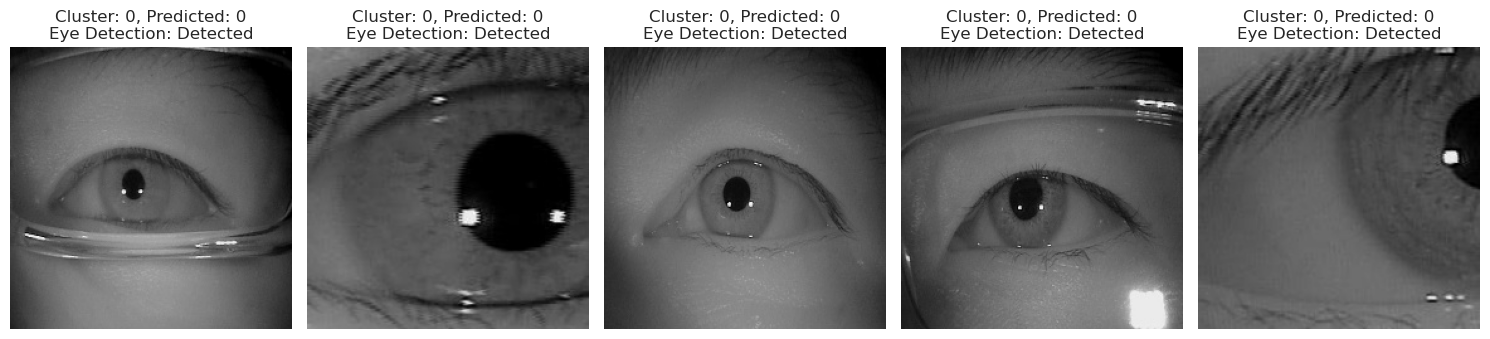

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Number of random images to select
num_samples = 5

# Randomly select images from the test set
random_images_indices = random.sample(range(len(test_images)), num_samples)
random_selected_images = [test_images[i] for i in random_images_indices]

# Preprocess the selected images
preprocessed_random_images = [preprocess_image(image) for image in random_selected_images]

# Extract features for selected images
random_features = extract_features(preprocessed_random_images)
random_features = random_features.reshape(random_features.shape[0], -1)

# Predict cluster labels for the random images
random_cluster_labels = kmeans.predict(random_features)

# Predict using the trained neural network model
predicted_probabilities = model.predict(random_features)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Define labels for eye detection
eye_detection_labels = [
    "Not Detected",
    "Detected"
]

# Display the output and images
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    cluster_label = random_cluster_labels[i]
    predicted_label = predicted_labels[i]
    eye_detection_status = eye_detection_labels[int(cluster_label == predicted_label)]
    
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cv2.cvtColor(random_selected_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Cluster: {cluster_label}, Predicted: {predicted_label}\nEye Detection: {eye_detection_status}")
    plt.axis('off')

plt.tight_layout()
plt.show()


125/125 [==============================] - 0s 2ms/step


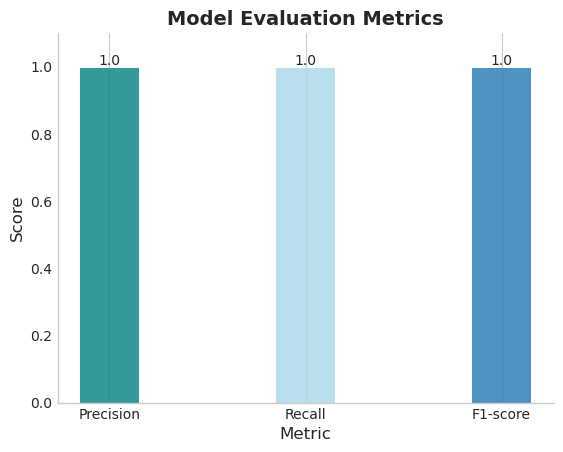

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Predict cluster labels for testing features
predicted_probabilities = model.predict(test_features)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate precision, recall, and F1-score
precision, recall, fscore, _ = precision_recall_fscore_support(test_cluster_labels, predicted_labels, average='weighted')

# Plot evaluation metric scores
metrics = ['Precision', 'Recall', 'F1-score']
scores = [precision, recall, fscore]

# Set custom colors for each bar
colors = ['#008080', '#a8d8ea', '#1f77b4']
bar_width = 0.3
bar_alpha = 0.8

plt.bar(metrics, scores, color=colors, width=bar_width, alpha=bar_alpha)
plt.title('Model Evaluation Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove spines and grid
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(False)

# Add text labels on top of the bars
for i, score in enumerate(scores):
    plt.text(i, score, str(round(score, 2)), ha='center', va='bottom', fontsize=10)

# Adjust vertical length
plt.ylim(0, 1.1)

# Show the plot
plt.show()


In [16]:
model.summary(line_length=80, positions=[0.30, 0.65, 0.80, 1.0])

Model: "sequential"
________________________________________________________________________________
 Layer (type)           Output Shape                Param #     
 flatten (Flatten)      (None, 512)                 0           
                                                                                
 dense (Dense)          (None, 128)                 65664       
                                                                                
 dropout (Dropout)      (None, 128)                 0           
                                                                                
 dense_1 (Dense)        (None, 64)                  8256        
                                                                                
 dense_2 (Dense)        (None, 2)                   130         
                                                                                
Total params: 74,050
Trainable params: 74,050
Non-trainable params: 0
__________________________________